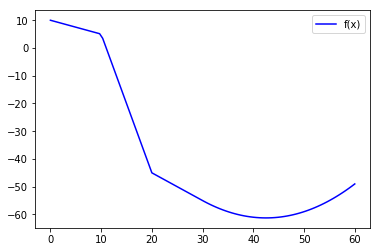

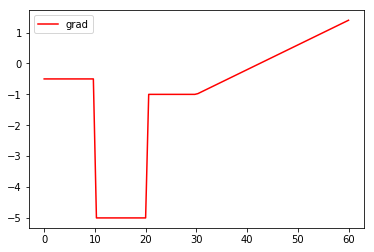

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

class Segment(object):
    
    def __init__(self, b, f):
        # assume start from 0
        self.b = b
        self.f = f
    
    def connectRight(self, other):
        # piece together line segments
        # assume self is on the left, other is on the right
        
        def f(x):
            f1b = self.f(self.b)
            f2b = other.f(self.b)

            if x <= self.b:
                return self.f(x)
            else:
                return other.f(x) - (f2b - f1b)
            
        return Segment(other.b, f)
        
    def plot(self, b=None, c='b'):
        x = np.linspace(0, b or self.b, 100)
        plt.plot(x, [self.f(x_) for x_ in x], label='f(x)', c=c)
        
    def plot_grad(self, b=None, c='b'):
        b = b or self.b
        grads = []
        xs = np.linspace(0, b, 100)
        for x in xs:
            x = torch.nn.Parameter(torch.Tensor([x]))
            y = s.forward(x)
            y.backward()
            grads.append(x.grad.item())
        plt.plot(xs, grads, label='grad', c=c)
        
    def forward(self, x):
        return self.f(x)
            
s1 = Segment(10, lambda x: -0.5*x + 10) # A
s2 = Segment(20, lambda x: -5*x) # D
s3 = Segment(30, lambda x: -1*x + 10) # A
s4 = Segment(100, lambda x: ((x-42.5)/5)**2) # E

s = s1.connectRight(s2).connectRight(s3).connectRight(s4)
s.plot(60)
plt.legend()
plt.show()

s.plot_grad(60, c='r')
plt.legend()
plt.show()
        
    

In [10]:
from lib.optimizer import Diff, Avrng, AdamVR

def get_path(opt, lr=1e-3, niter=30000, verbose=False, grad_noise=0):
    path = []
    p = torch.nn.Parameter(torch.Tensor([0])) # start from 0
    optimizer = opt([p], lr=lr)

    for i in range(niter):
        path.append(p.item())
        if i % 500 == 0 and verbose:
            print('x[{}]={}'.format(i, p.item()))
            
        # sample input
        delta = np.random.choice([-1, -1, -1, 3])
        def closure():
            optimizer.zero_grad()
            l = s.forward(p) # p is parameter, s is the curve
            l.backward()
            p.grad.data.add_(grad_noise * delta)
            return l

        l = optimizer.step(closure)
    
    return path

grad_noise=3.0
res = {}
optimizations = [AdamVR, torch.optim.Adam, torch.optim.SGD] # previously use Diff
for opt in optimizations:
    xs = get_path(opt, grad_noise=grad_noise, verbose=False, niter=30000)
    opt_name = opt.__name__.split('.')[-1]
    res[opt_name] = xs
    print('{} done: {}'.format(opt_name, xs[-1]))

AdamVR done: 14.515164375305176
Adam done: 2.865861177444458
SGD done: 29.51441764831543


In [11]:
import matplotlib.animation as animation
colors = ['orange', 'green', 'red', 'black']

fig = plt.figure(figsize=(6, 6))
ax = plt.axes()

s.plot(60)
balls = [plt.Circle([0, s.forward(0)], 2, color=colors[i]) for i in range(len(optimizations))]
balls_text = [ax.text(0,5,opt.__name__.split('.')[-1]) for opt in optimizations]
for i in range(len(optimizations)):
    ax.add_artist(balls[i])

def animate(i):
    idx = i*50
    for i, opt in enumerate(optimizations):
        opt_name = opt.__name__.split('.')[-1]
        balls[i].center = [res[opt_name][idx], s.forward(res[opt_name][idx])]
        balls_text[i].set_position([res[opt_name][idx], s.forward(res[opt_name][idx])-5])
    return tuple(balls) + tuple(balls_text)

anim = animation.FuncAnimation(fig, animate, frames=600, interval=40, blit=True)

In [12]:
from IPython.display import HTML,Image
HTML(anim.to_html5_video())

In [94]:
#anim.save('opt_videos/{}.mp4'.format(opt_name))
anim.save('opt_videos/opt_gradnoise{:.2f}.gif'.format(grad_noise), writer='imagemagick', fps=60)

In [ ]:
#from IPython.display import HTML,Image
#Image('opt_videos/opt.gif')